In [11]:
%matplotlib inline

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hbam
import pickle

from tqdm.notebook import tqdm
from itertools import combinations


## Experiment 1

Similarity of graphs w.r.t. a single type of manipulation

- for each manipulation
    - for each family of graphs
        - create `NUM_ITERATIONS` of graphs where each graph is a
        single manipulation of the previous graph
        - for each weighting function
            - compute similarity between each pair of graphs and
            denote the distance between the graphs

In [19]:
NUM_NODES = 50
NUM_ITERATIONS = 5

ACTIONS = list(hbam.ACTIONS.keys() )+ [None]

GRAPHS = []

G1 = nx.erdos_renyi_graph(n=NUM_NODES, p=0.02)
G2 = nx.watts_strogatz_graph(n=NUM_NODES, p=0.01, k=2)
G3 = nx.barabasi_albert_graph(n=NUM_NODES, m=2)
G4 = nx.waxman_graph(n=NUM_NODES, alpha=0.2, beta=0.5)

for action in ACTIONS:
    for i in range(NUM_ITERATIONS):
        G1 = hbam.modify(G1, action=action)
        G2 = hbam.modify(G2, action=action)
        G3 = hbam.modify(G3, action=action)
        G4 = hbam.modify(G4, action=action)

        GRAPHS.append((i, 'erdos', G1, action))
        GRAPHS.append((i, 'watts', G2, action))
        GRAPHS.append((i, 'barabasi', G3, action))
        GRAPHS.append((i, 'waxman', G4, action))

In [21]:
WEIGHTS = ['linear', 'exponential', 'stepwise']

RESULTS = []

for ((ig, tg, g, ag), (ih, th, h, ah)) in combinations(GRAPHS, r=2):
    if tg == th and ag == ah:
        eg = hbam.embed(nx.to_numpy_array(g))
        eh = hbam.embed(nx.to_numpy_array(h))
        for weight in WEIGHTS:
            w = hbam.get_weights(hbam.EMBEDDING_SIZE, weight)
            RESULTS.append((ih-ig, tg, ag, weight, hbam.cosine(eg, eh, w)))

In [4]:
df = pd.DataFrame(RESULTS, columns=['distance', 'family', 'modification', 'weight', 'similarity'])

with open('ex1-ex2-data.p', 'wb') as f:
    pickle.dump(df, f)


TITLE = {
    'erdos': 'Erdos-Renyi random model',
    'watts': 'Watts-Strogatz small world model',
    'barabasi': 'Albert-Barabasi scale free model',
    'waxman': 'Waxman geometrical random model',
    'linear': 'linear weight',
    'exponential': 'exponential weight',
    'add_node': 'adding a random node',
    'del_node': 'removing a random node',
    'add_edge': 'adding a random edge',
    'del_edge': 'removing a random edge',
    'change_edge': 're-wiring a random edge'
}

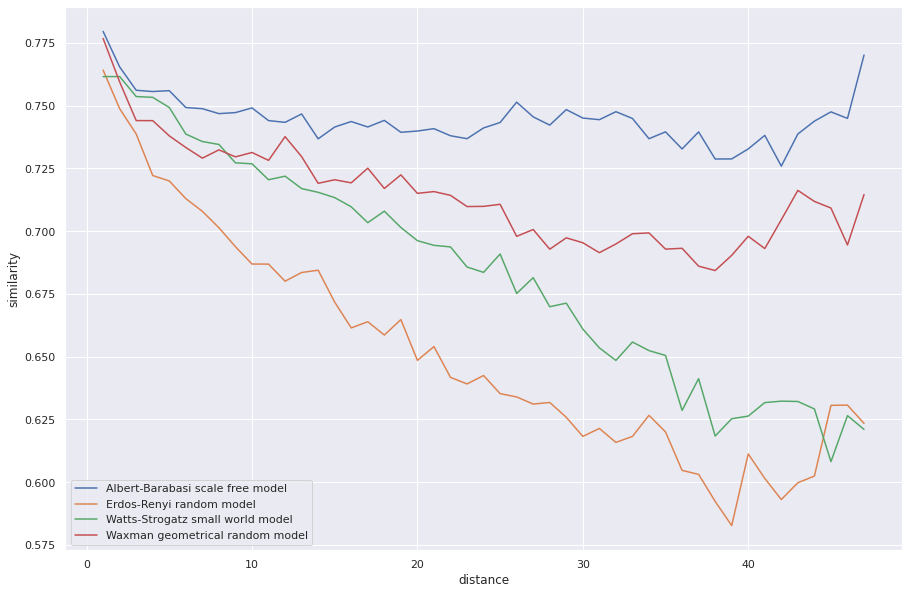

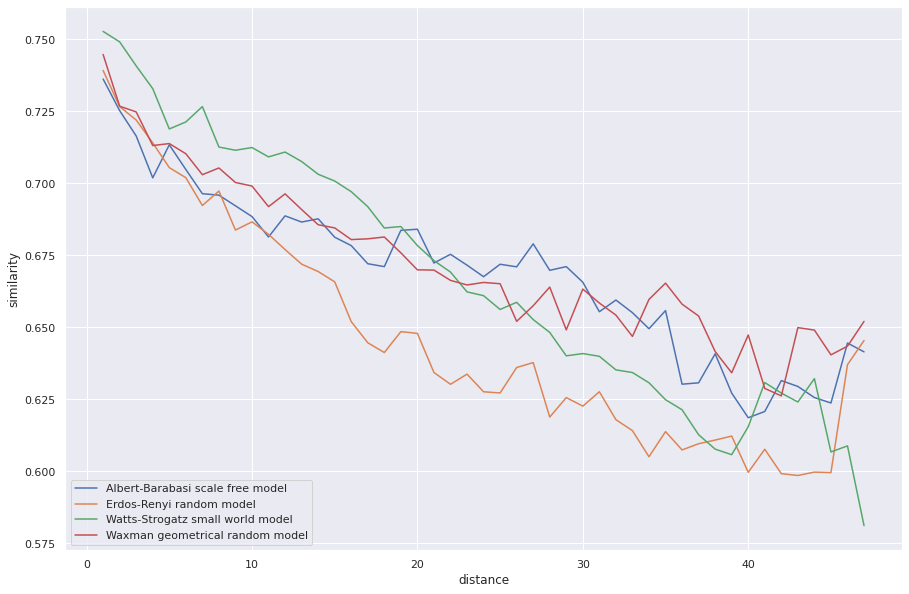

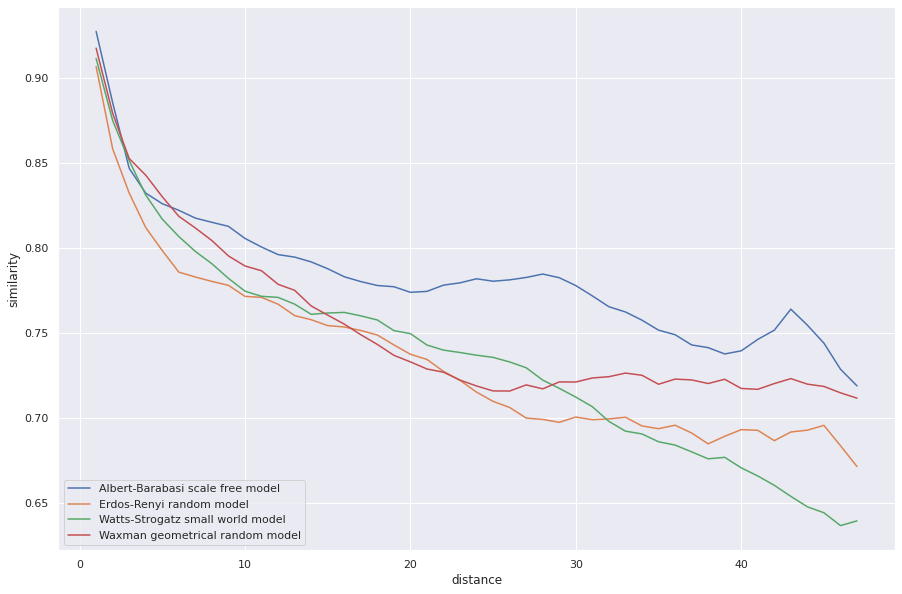

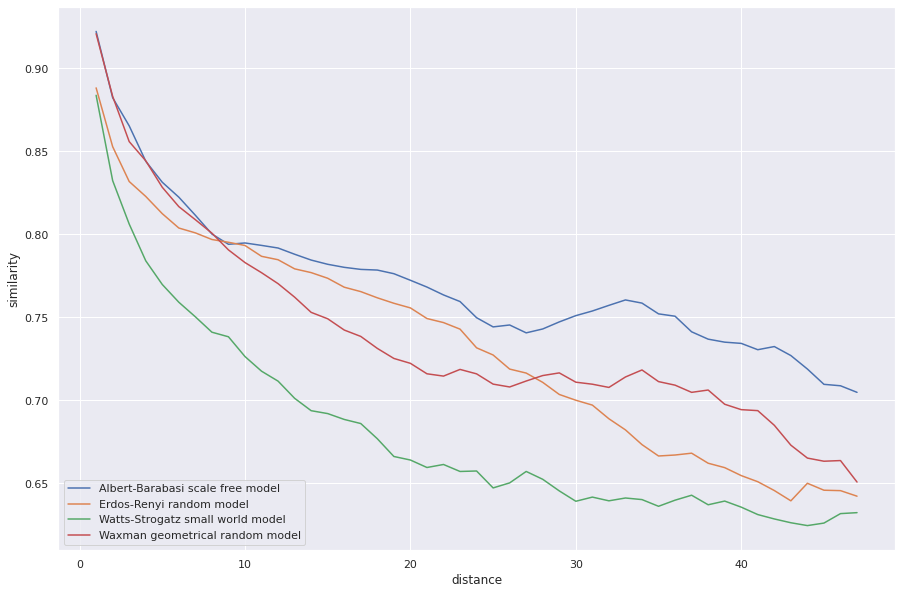

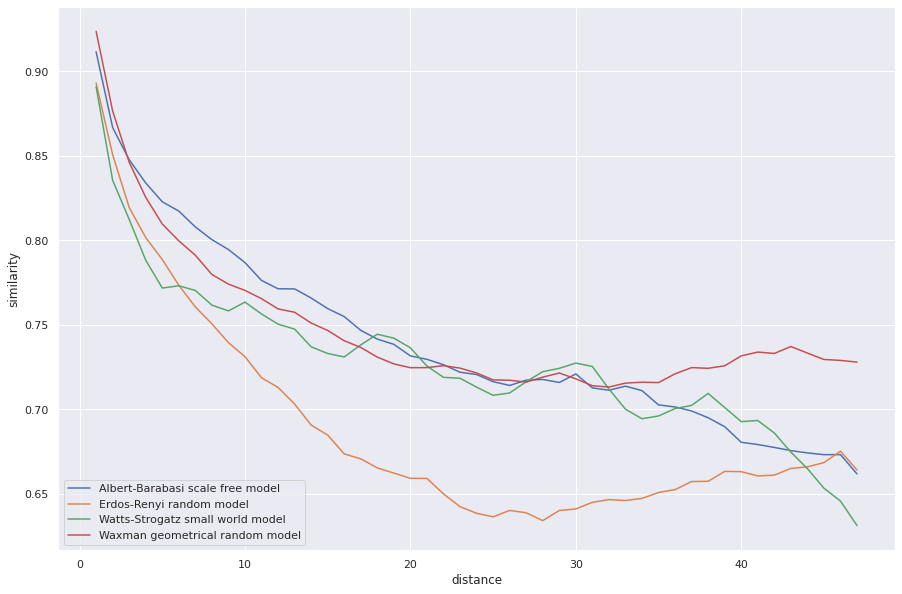

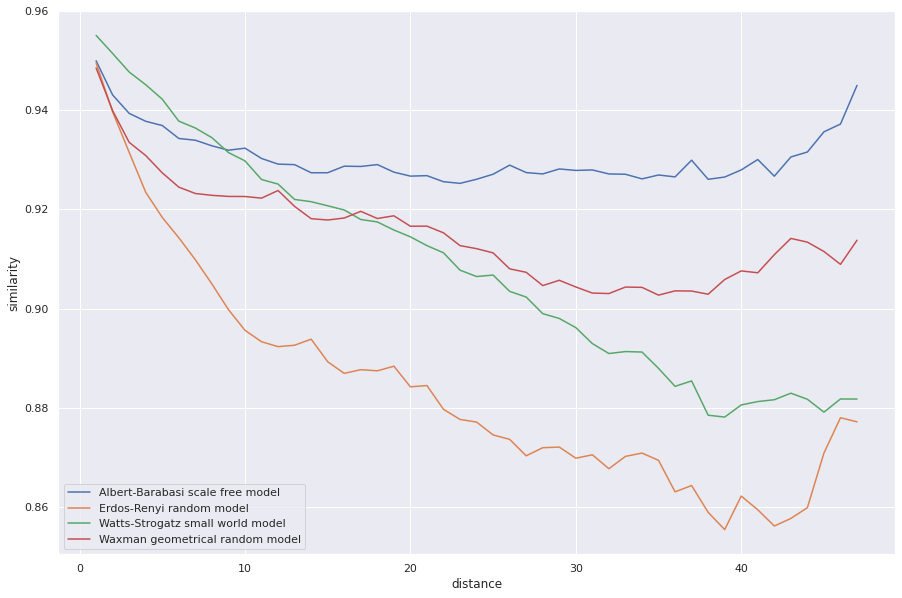

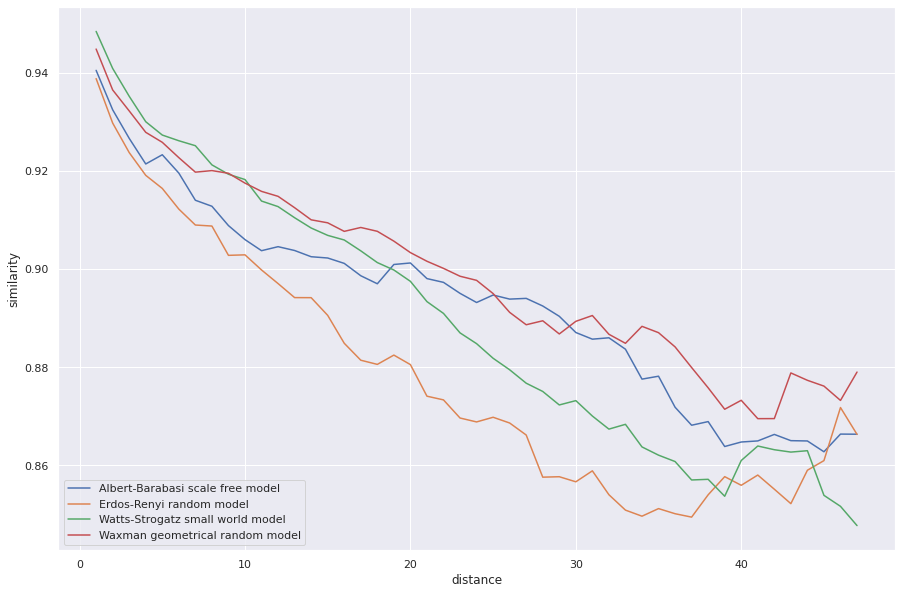

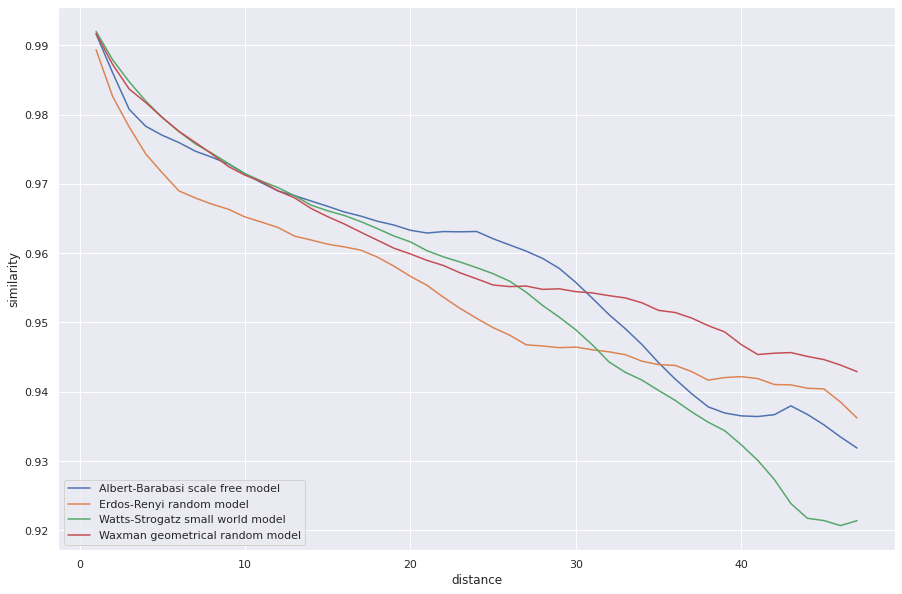

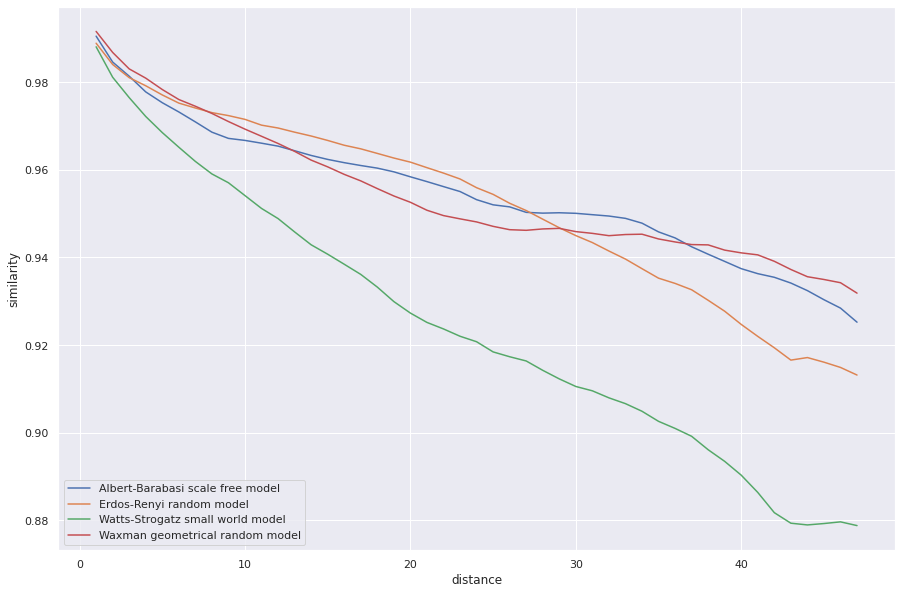

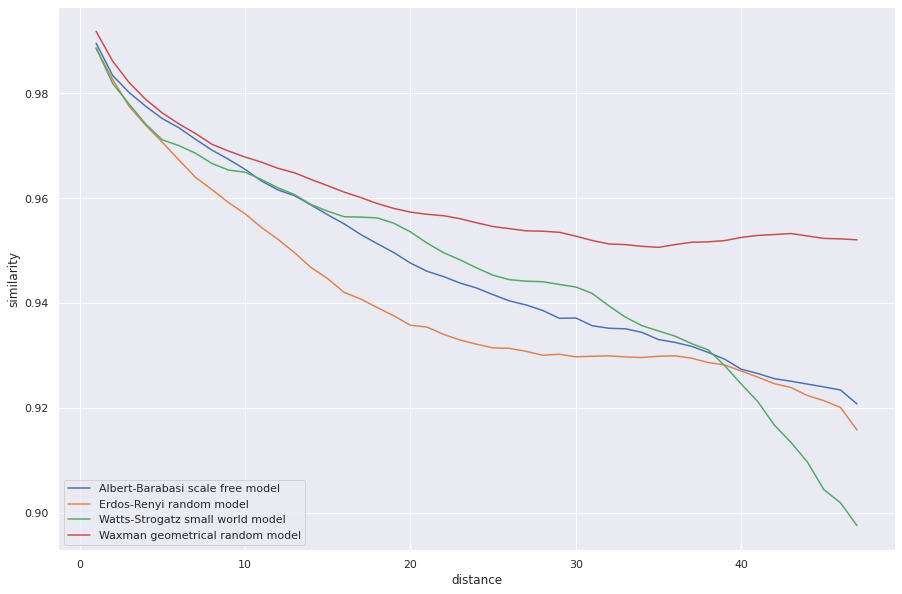

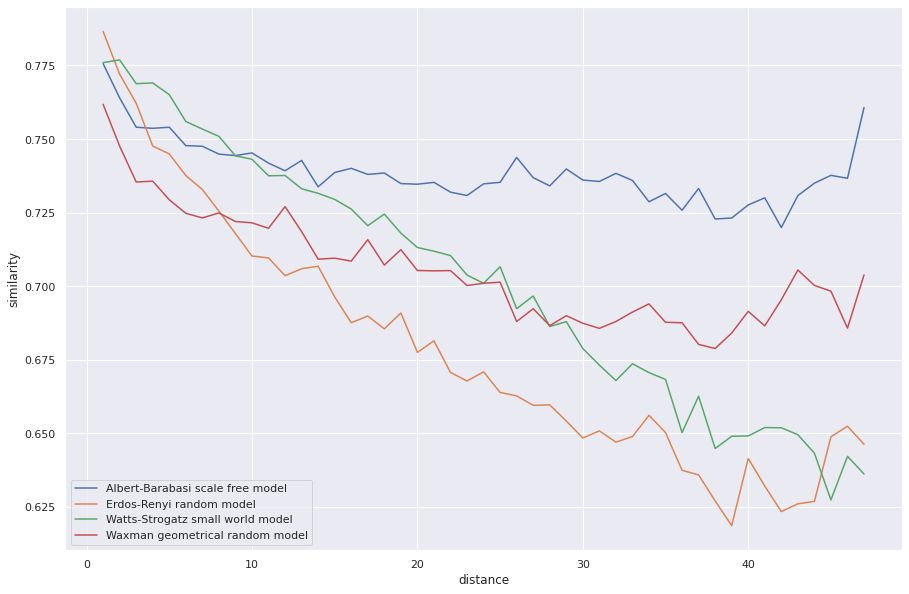

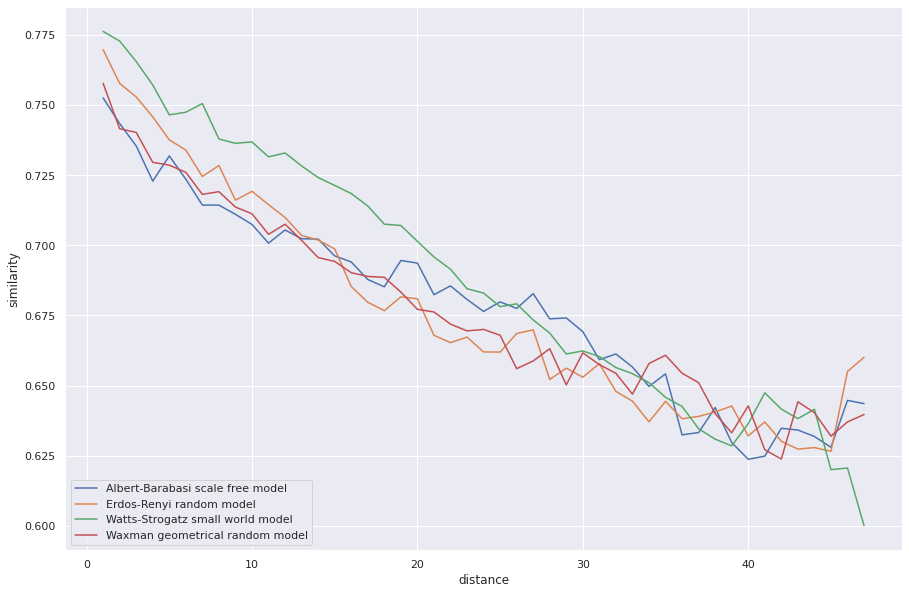

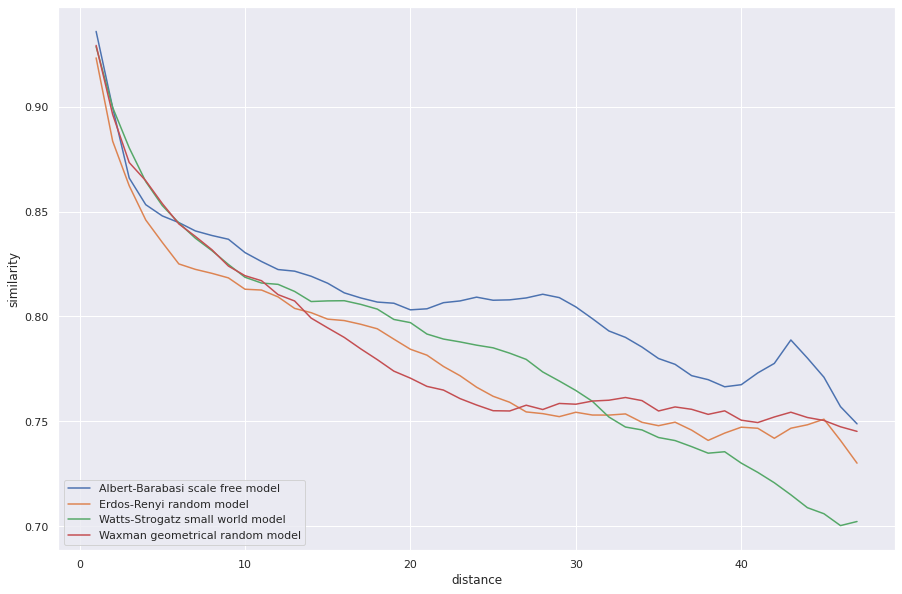

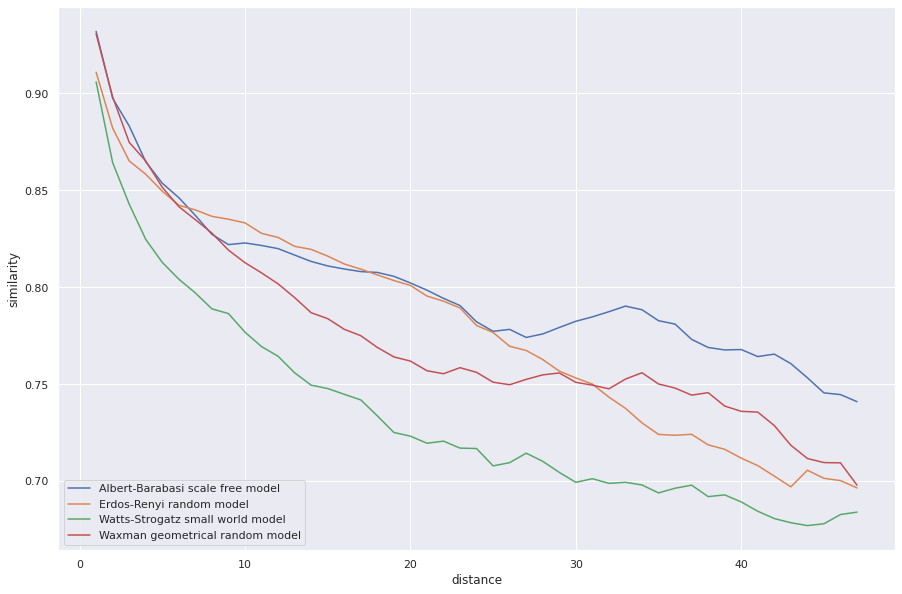

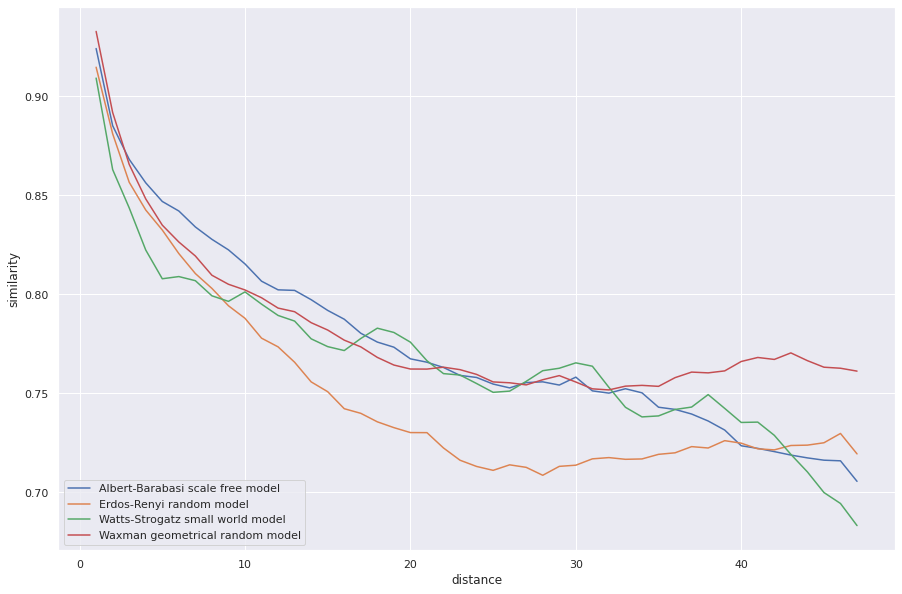

In [5]:
with open('ex1-ex2-data.p', 'rb') as f:
    df = pickle.load(f)

for weight in ['linear', 'exponential', 'stepwise']:
    for action in ['add_node', 'del_node', 'add_edge', 'del_edge', 'change_edge']:

        idx = (df.modification == action) & (df.weight == weight) & (df.distance < 48)
        df_g = df[idx].groupby(by=['distance', 'family']).mean().reset_index()

        filename = f"figures/fig-{action}-{weight}-n{NUM_NODES}.png"

        sns.set(rc={'figure.figsize':(15,10)})
        plot = sns.lineplot(x=df_g.distance, y=df_g.similarity, hue=df_g.family, legend=False)
        plt.legend(loc='lower left', labels=[TITLE['barabasi'], TITLE['erdos'], TITLE['watts'], TITLE['waxman']])
        plt.show(plot)
        plot.figure.savefig(filename)

## Experiment 2

Similarity of graphs w.r.t. a random type of manipulation

- for each family of graphs
    - create `NUM_ITERATIONS` of graphs where each graph is a
    random manipulation of the previous graph
    - for each weighting function
        - compute similarity between each pair of graphs and
        denote the distance between the graphs

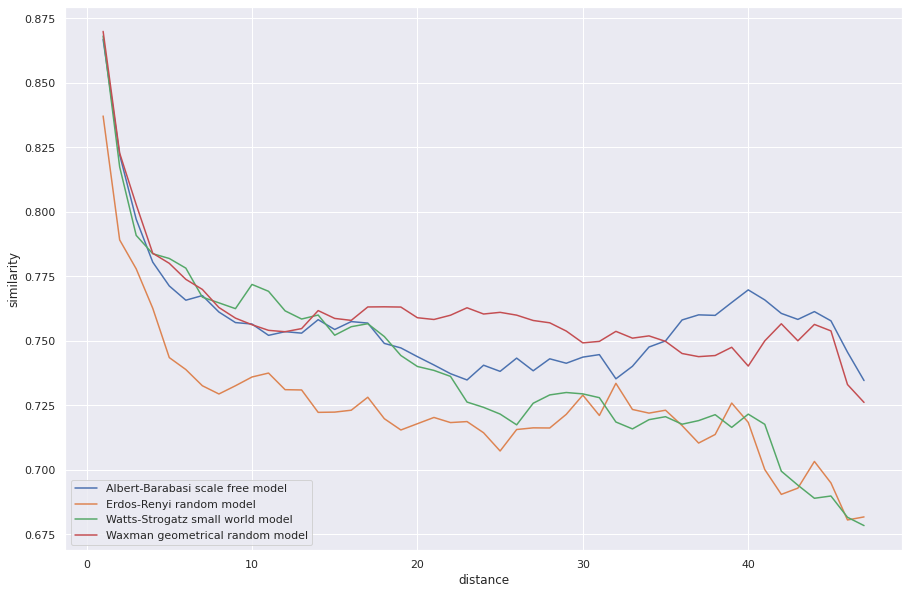

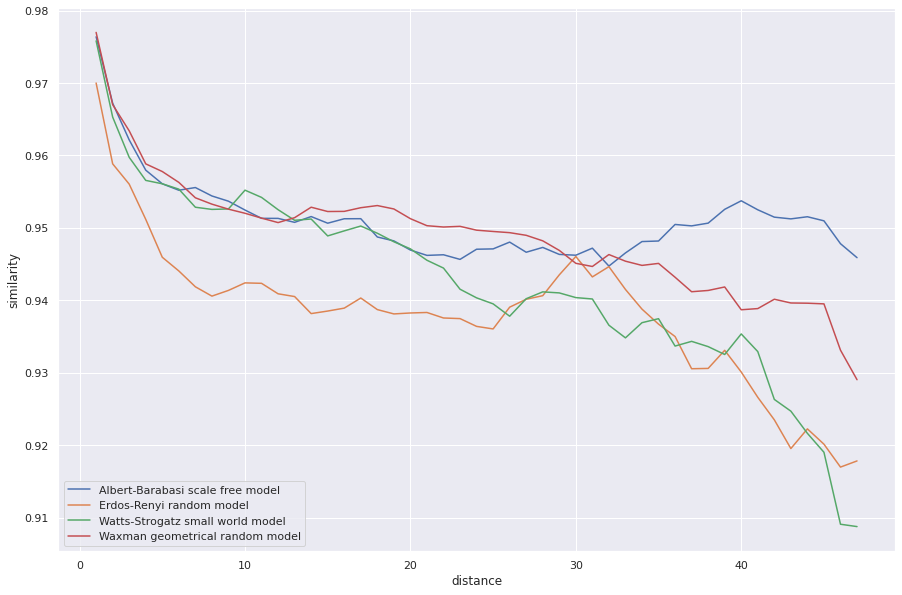

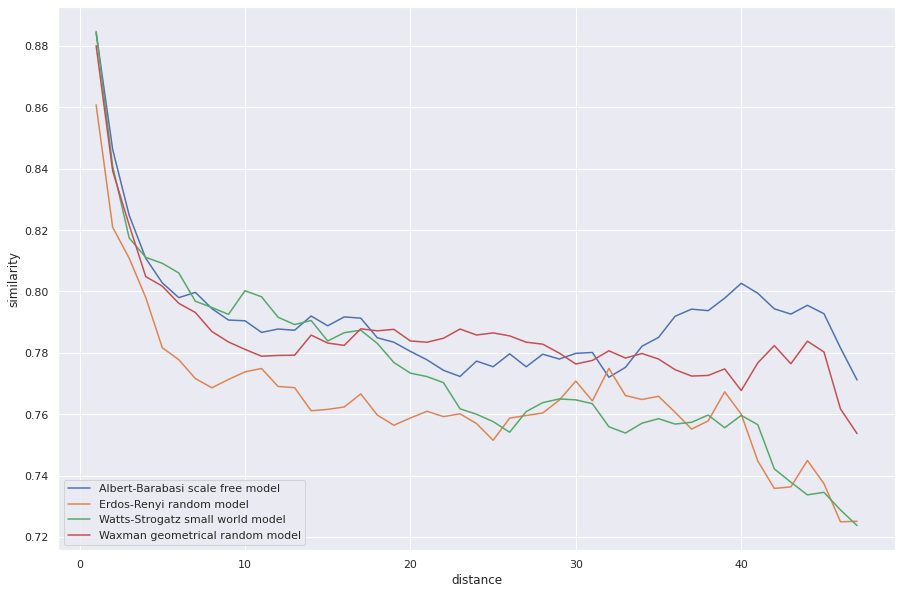

In [6]:
for weight in ['linear', 'exponential', 'stepwise']:
    idx = (df.modification.isna()) & (df.weight == weight) & (df.distance < 48)
    df_g = df[idx].groupby(by=['distance', 'family']).mean().reset_index()

    filename = f"figures/fig-random-action-{weight}-n{NUM_NODES}.png"

    sns.set(rc={'figure.figsize':(15,10)})
    plot = sns.lineplot(x=df_g.distance, y=df_g.similarity, hue=df_g.family, legend=False)
    plt.legend(loc='lower left', labels=[TITLE['barabasi'], TITLE['erdos'], TITLE['watts'], TITLE['waxman']])
    plt.show(plot)
    plot.figure.savefig(filename)



## Experiment 3

Graph isomorphism

The idea of the experiment is to generate several isomorphisms of a given graph and then to check the average
cosine similarity between these isomorphic graphs.


In [7]:
ISO_GRAPHS = []
SIMILARITIES = []

G1 = nx.erdos_renyi_graph(n=NUM_NODES, p=0.02)
G2 = nx.watts_strogatz_graph(n=NUM_NODES, p=0.01, k=2)
G3 = nx.barabasi_albert_graph(n=NUM_NODES, m=2)
G4 = nx.waxman_graph(n=NUM_NODES, alpha=0.2, beta=0.5)

for g,t in zip([G1, G2, G3, G4], ['erdos', 'watts', 'barabasi', 'waxman']):
    for _ in tqdm(range(NUM_ITERATIONS)):
        ISO_GRAPHS.append((t, hbam.permute(g)))

for weight in ['linear', 'exponential', 'stepwise']:
    w = hbam.get_weights(hbam.EMBEDDING_SIZE, weight)
    for ((tx, x), (ty, y)) in tqdm(combinations(ISO_GRAPHS, r=2)):
        if tx == ty:
            ex = hbam.embed(nx.to_numpy_array(x, nodelist=[n for n,d in sorted(list(x.degree), key=lambda l: l[1], reverse=True)]))
            ey = hbam.embed(nx.to_numpy_array(y, nodelist=[n for n,d in sorted(list(y.degree), key=lambda l: l[1], reverse=True)]))
            SIMILARITIES.append((tx, weight, hbam.cosine(ex, ey, w)))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [9]:
df = pd.DataFrame(SIMILARITIES, columns=['model', 'weight', 'similarity'])

with open('ex3-data.p', 'wb') as f:
    pickle.dump(df, f)

df.groupby(['model', 'weight']).mean().reset_index()

,model,weight,similarity
0,barabasi,exponential,1.0
1,barabasi,linear,1.0
2,barabasi,stepwise,1.0
3,erdos,exponential,1.0
4,erdos,linear,1.0
5,erdos,stepwise,1.0
6,watts,exponential,1.0
7,watts,linear,1.0
8,watts,stepwise,1.0
9,waxman,exponential,1.0


## Weighting functions

Three functions are used to provide a weight vector for the modified cosine distance:

- linear weight: linear decay of the weight of dimensions
- exponential weight: the weight of dimension $d$ is $\frac{1}{d}$
- stepwise weight: the weight goes down as dimensions represent next levels


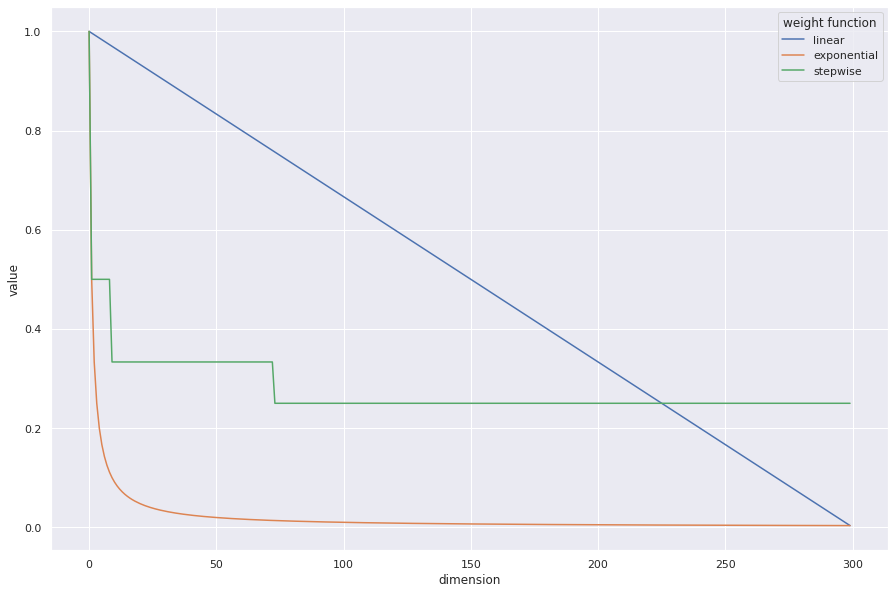

In [12]:
df = pd.DataFrame({
    'dimension': range(hbam.EMBEDDING_SIZE),
    'linear': hbam.get_weights(hbam.EMBEDDING_SIZE, 'linear'),
    'exponential': hbam.get_weights(hbam.EMBEDDING_SIZE, 'exponential'),
    'stepwise': hbam.get_weights(hbam.EMBEDDING_SIZE, 'stepwise'),
})
df_plot = pd.melt(df, 'dimension', var_name='weight function')

plot = sns.lineplot(data=df_plot, x='dimension', y='value', hue='weight function')
plt.show(plot)
plot.figure.savefig('figures/fig-weight-functions.png')